**Welcome to pyLIMA (v2) tutorial 3!**

In this tutorial you will learn how you can use pyLIMA to simulate a microlensing 
light curve. 

We will cover how to call the pyLIMA microlensing simulator and generate 
sample light curves.

We will also fit these light curves and see if we can recover the input parameters.

Please take some time to familiarize yourself with the pyLIMA documentation.

In [1]:
### Import the required libraries.
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os, sys

from pyLIMA import event
from pyLIMA import telescopes

Import the simulator to be used for generating the simulated light curve

In [2]:
from pyLIMA.simulations import simulator

Create a new EVENT object and give it a name.
You can also set the coordinates for an event.

In the context of the simulation, the coordinates will be used to check whether the target is observable from a specific observatory.

In [3]:
your_event = event.Event()
your_event.name = 'My simulated event'
your_event.ra = 270
your_event.dec = -30

Create some telescope(s) to observe the event from. 

The function we will use will create a generic telescope class (see pyLIMA documentation for details). 

We will need to create a new telescope for each observatory, telescope, filter combination. 

Let us start simple and generate a single telescope first. We will also set uniform_sampling=True, which will make sure the light curve generated will not have any gaps due to the night/day cycle.

In [4]:
CTIO_I = simulator.simulate_a_telescope('CTIO_I', your_event, 2457365.5,2457965.5, 4, 'Earth', 'I',
                                        uniform_sampling=True)

Similar to tutorial 1, we need to associate this telescopee with the event we created:

In [5]:
your_event.telescopes.append(CTIO_I)

Run a quick sanity check on your input.

In [6]:
your_event.check_event()

check_event  : Everything looks fine...


Now construct the **MODEL** you want to deploy to construct the light curves and link it to the **EVENT** you prepared.

We will use a simple point-lens point-source (PSPL) model in this example.

In [7]:
from pyLIMA.models import PSPL_model
pspl = PSPL_model.PSPLmodel(your_event)

Now that the **MODEL** is there, we need to set the relevant parameters.

The parameters are drawn uniformly from the bounds defined but you can also set them manually. Please consult the documentation for more details on the parameters of the **MODEL** you want to use. For the PSPL example, pspl_parameters = [to, uo, tE, flux_source, flux_blend]

In [8]:
pspl_parameters = simulator.simulate_microlensing_model_parameters(pspl)
print (pspl_parameters)

[2457895.068952857, 0.3799121408017151, 484.12390916631057, 776630.7870185563, 1989.144306811822]


Recall that to see the order and names of the paramaters you can always use:

In [9]:
pspl.model_dictionnary

OrderedDict([('t0', 0),
             ('u0', 1),
             ('tE', 2),
             ('fsource_CTIO_I', 3),
             ('fblend_CTIO_I', 4)])

Transform the parameters into a pyLIMA class object. See the documentation for details.

In [10]:
pyLIMA_parameters_1 = pspl.compute_pyLIMA_parameters(pspl_parameters)

Now we have defined the **MODEL** we want to simulate, we have defined the telescope details, so we just inject these into our simulator to produce a light curve:

In [11]:
simulator.simulate_lightcurve_flux(pspl, pyLIMA_parameters_1)

Let's plot our simulated light curve using the pyLIMA plotter (recommended)!

/home/Tux/ytsapras/Installed_Programs/anaconda3/envs/pylima2/lib/python3.9/site-packages/pyLIMA-0.8.3-py3.9.egg/pyLIMA/telescopes.py:237: RuntimeWarning: divide by zero encountered in divide
  inv_err_flux = 1.0/err_flux
/home/Tux/ytsapras/Installed_Programs/anaconda3/envs/pylima2/lib/python3.9/site-packages/pyLIMA-0.8.3-py3.9.egg/pyLIMA/toolbox/plots.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  figure_axe.errorbar(time, mag, mag_error, fmt='.', color=color, marker=marker, label=name)


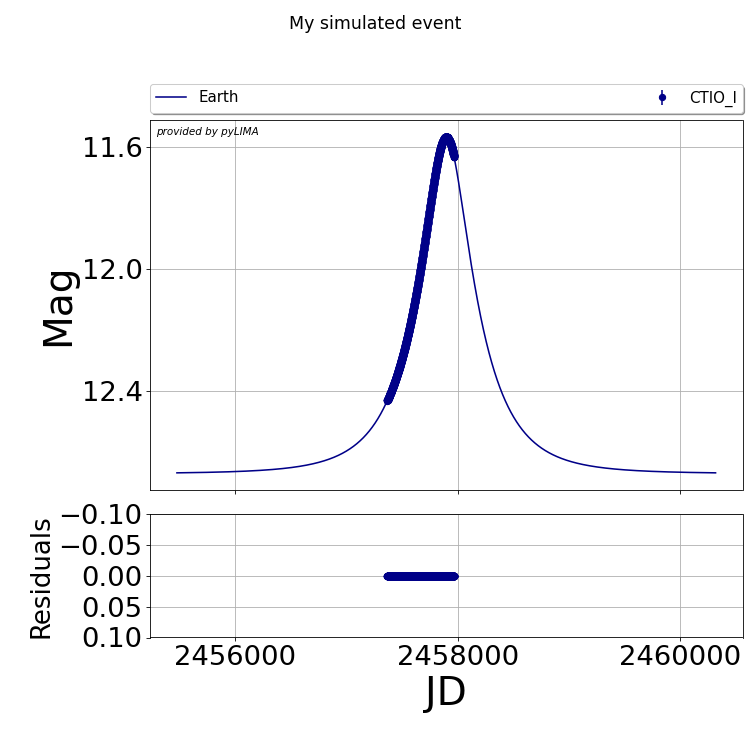

In [12]:
from pyLIMA.outputs import pyLIMA_plots
pyLIMA_plots.plot_lightcurves(pspl, pspl_parameters)
plt.show()

... or you can just plot the results yourself any way you want to using matplotlib

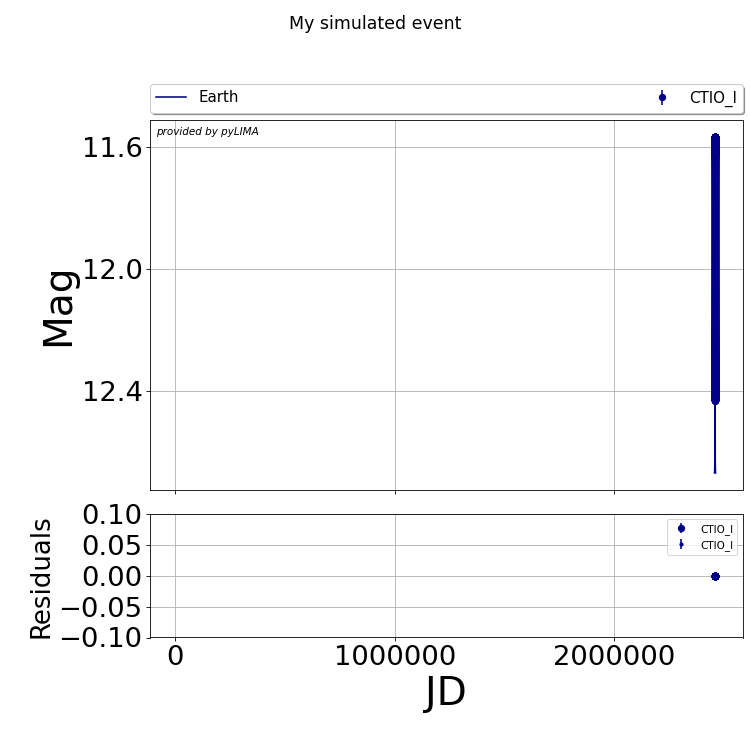

In [13]:
plt.errorbar(CTIO_I.lightcurve_magnitude['time'].value-2450000,
             CTIO_I.lightcurve_magnitude['mag'].value,
             yerr = CTIO_I.lightcurve_magnitude['err_mag'].value,
             fmt = '.', label=CTIO_I.name)

plt.gca().invert_yaxis()
plt.legend()
plt.show()

OK, so now we want to simulate something more complicated. 

Say, we have multiple telescopes around the world imaging the event in different bands and at different time intervals.

In addition, we also want to simulate bad weather, avoid pointing too close to the moon, and also account for observing limitations due to the location of the target in the sky relative to the Sun. (For a full list of the options available please consult the documentation!)

Let's create a new event to observe:

In [14]:
your_event2 = event.Event()
your_event2.name = 'My simulated event 2'
your_event2.ra = 264
your_event2.dec = -28

We will simulate telescopes in South Africa (SAAO),  Chile (CTIO) and Australia (SSO).

For observing bands, we're simulate I-band for all sites, and also add a daily V-band observation from CTIO. Each observing band counts as a seperate telescope, so we will need to create _four_ telescope objects:

In [15]:
SAAO_I = simulator.simulate_a_telescope('SAAO_I', your_event2, 2457575.5, 2457625.5, 2.5, 'Earth','I',
                                        uniform_sampling=False, altitude=400, longitude = 20.659279, 
                                        latitude = -32.3959, bad_weather_percentage=20.0 / 100, 
                                        moon_windows_avoidance=20, minimum_alt=15)

SSO_I = simulator.simulate_a_telescope('SSO_I', your_event2, 2457535.5, 2457645.5, 2.5, 'Earth','I',
                                        uniform_sampling=False, altitude=1165, longitude = 149.0685, 
                                        latitude = -31.2749, bad_weather_percentage=35.0 / 100, 
                                        moon_windows_avoidance=20, minimum_alt=15)

CTIO_I = simulator.simulate_a_telescope('CTIO_I', your_event2, 2457365.5, 2457965.5, 4.5, 'Earth', 'I',
                                        uniform_sampling=False, altitude=1000, longitude = -109.285399, 
                                        latitude = -27.130, bad_weather_percentage=10.0 / 100, 
                                        moon_windows_avoidance=30, minimum_alt=30)

CTIO_V = simulator.simulate_a_telescope('CTIO_V', your_event2, 2457365.5, 2457965.5, 24.5, 'Earth', 'V',
                                        uniform_sampling=False, altitude=1000, longitude = -109.285399, 
                                        latitude = -27.130, bad_weather_percentage=10.0 / 100, 
                                        moon_windows_avoidance=30, minimum_alt=30)

The meaning of the parameters, in this example, for the SAAO_I data set are:
Name = SAAO_I, your_event2, location = 'Earth', start_obs =2457585.5, end_obs = 2457615.5,
sampling(hours) = 2, location='Earth', filter = 'I', uniform_sampling=True, altitude = 400 m, 
longitude = 20.659279, latitude = -32.3959, bad_weather_percentage = 20%, 
moon_windows_avoidance (degrees)=20, minimum_alt=15)

Associate these telescopes with the event we created:

In [16]:
your_event2.telescopes.append(SAAO_I)
your_event2.telescopes.append(SSO_I)
your_event2.telescopes.append(CTIO_I)
your_event2.telescopes.append(CTIO_V)

Run a quick sanity check on your input.

In [17]:
your_event2.check_event()

check_event  : Everything looks fine...


Define which data set to align all data to (optional):

In [18]:
your_event2.find_survey('CTIO_I')

Now construct the **MODEL** you want to deploy to construct the light curves and link it to the **EVENT** you prepared.

We will use the double-source point-lens (DSPL) model for this example.

In [19]:
from pyLIMA.models import DSPL_model
dspl = DSPL_model.DSPLmodel(your_event2)

Now that the MODEL is there, we need to set the relevant parameters.

The parameters are drawn uniformly from the bounds defined but you can also set them manually. Please consult the documentation for more details on the parameters of the MODEL you want to use. For the DSPL example, dspl_parameters = [to, uo, delta_to, delta_uo, tE, q_fluxr_1, q_fluxr2, ...]
where q_fluxr_* is the flux ratio in each observing band.

In [20]:
dspl_parameters = simulator.simulate_microlensing_model_parameters(dspl)
print (dspl_parameters)

[2457444.8224290772, 0.10818964038956091, -144.23882656410692, -0.9482879853639721, 24.121402990438593, 0.4525806620020566, 0.43843192698800465, 16620.308671155715, 310.9739874359868, 12573.551570283684, 1641.2584021278228, 97237.4336605312, 914.1330468541232, 19770.332868931942, 170.37017619345318]


To see the order and names of the paramaters use:

In [21]:
dspl.model_dictionnary

OrderedDict([('t0', 0),
             ('u0', 1),
             ('delta_t0', 2),
             ('delta_u0', 3),
             ('tE', 4),
             ('q_flux_I', 5),
             ('q_flux_V', 6),
             ('fsource_CTIO_I', 7),
             ('fblend_CTIO_I', 8),
             ('fsource_SAAO_I', 9),
             ('fblend_SAAO_I', 10),
             ('fsource_SSO_I', 11),
             ('fblend_SSO_I', 12),
             ('fsource_CTIO_V', 13),
             ('fblend_CTIO_V', 14)])

pyLIMA has provided some random values for the fluxes drawn from uniform distributions.

These do not represent any physical system and are likely off for the telescope/filter combination that you as a user have defined, but they can be used as placeholders for you to define your own values. We will see how to do that later. For now, just use these temporary values for the simulation.

Transform the parameters into pyLIMA standards:

In [22]:
pyLIMA_parameters = dspl.compute_pyLIMA_parameters(dspl_parameters)

Now we have defined the MODEL we want to simulate, we have defined the telescopes and fluxes in each observing band, so we just inject these into our simulator to produce a light curve:

In [23]:
simulator.simulate_lightcurve_flux(dspl, pyLIMA_parameters)

Let's plot our simulated light curve!

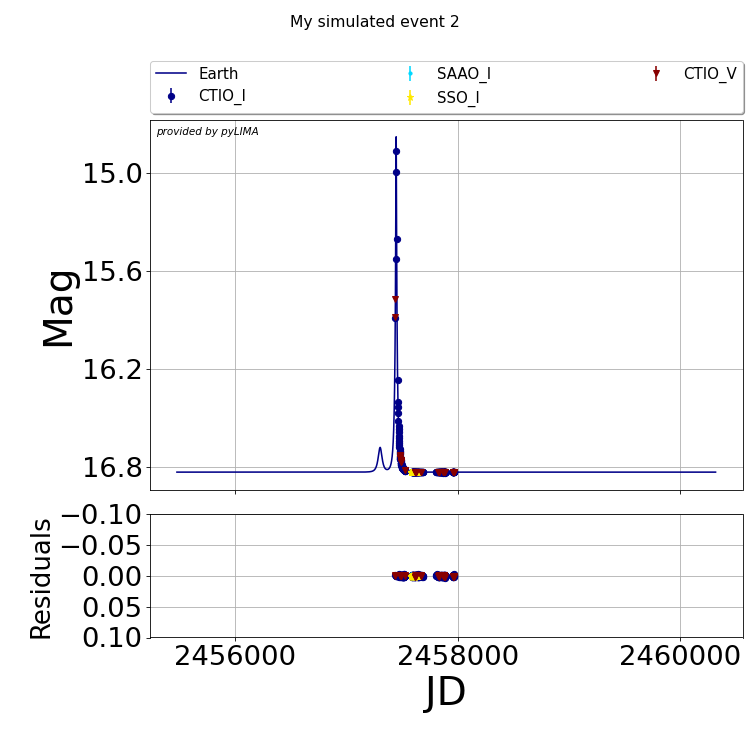

In [24]:
### Plot with pyLIMA plotter (recommended):
from pyLIMA.outputs import pyLIMA_plots
pyLIMA_plots.plot_lightcurves(dspl, dspl_parameters)
plt.show()

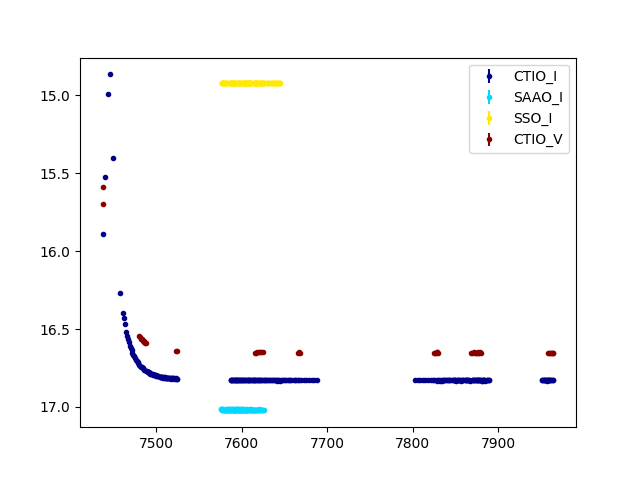

In [25]:
### ... or plot it all manually if you prefer:
for telescope in your_event2.telescopes:
    plt.errorbar(telescope.lightcurve_magnitude['time'].value-2450000,
                 telescope.lightcurve_magnitude['mag'].value,
                 yerr=telescope.lightcurve_magnitude['err_mag'].value, 
                 fmt='.', label=telescope.name)

plt.gca().invert_yaxis()
plt.legend()
plt.show()

Say you want to define your own values to use, instead of having the pyLIMA simulators randomly guess.

Here's how you can do that. Let's fix the DSPL parameters to some values where the binary source model produces two clear peaks, and then just adjust the flux parameters.

In [26]:
dspl_parameters[0:7] = [2457760.216627234, 0.8605811108889658, 143.4484970433387, -0.6046788112617074, 116.43231096591524, 0.15157064165919296, 0.18958495421162946]

The order of the parameters is:

In [27]:
dspl.model_dictionnary

OrderedDict([('t0', 0),
             ('u0', 1),
             ('delta_t0', 2),
             ('delta_u0', 3),
             ('tE', 4),
             ('q_flux_I', 5),
             ('q_flux_V', 6),
             ('fsource_CTIO_I', 7),
             ('fblend_CTIO_I', 8),
             ('fsource_SAAO_I', 9),
             ('fblend_SAAO_I', 10),
             ('fsource_SSO_I', 11),
             ('fblend_SSO_I', 12),
             ('fsource_CTIO_V', 13),
             ('fblend_CTIO_V', 14)])

... and we will replace all source and blend flux elements with our own values. We can assume the fluxes are calibrated. Set up the magnitude values you want:

In [28]:
magsource_CTIO_I = 17.32
magblend_CTIO_I = 20.89
magsource_SAAO_I = 17.32
magblend_SAAO_I = 20.89
magsource_SSO_I = 17.32
magblend_SSO_I = 20.89
magsource_CTIO_V = 19.18
magblend_CTIO_V = 21.22

Now we need to convert these to fluxes. Set up an empty array to hold the values:

In [29]:
fluxes = []

Import the magnitude to flux coversion function from pyLIMA and populate the array

In [30]:
from pyLIMA.toolbox import brightness_transformation
for mag in [magsource_CTIO_I, magblend_CTIO_I, magsource_SAAO_I, magblend_SAAO_I,
            magsource_SSO_I, magblend_SSO_I, magsource_CTIO_V, magblend_CTIO_V]:
    flux = brightness_transformation.magnitude_to_flux(mag)
    fluxes.append(flux)

Now we add these fluxes to the dspl_parameters we prepared earlier:

In [31]:
dspl_parameters[7:] = fluxes

Transform the parameters into pyLIMA standards:

In [32]:
pyLIMA_parameters = dspl.compute_pyLIMA_parameters(dspl_parameters)

Produce the lightcurve:

In [33]:
simulator.simulate_lightcurve_flux(dspl, pyLIMA_parameters)

Plot it:

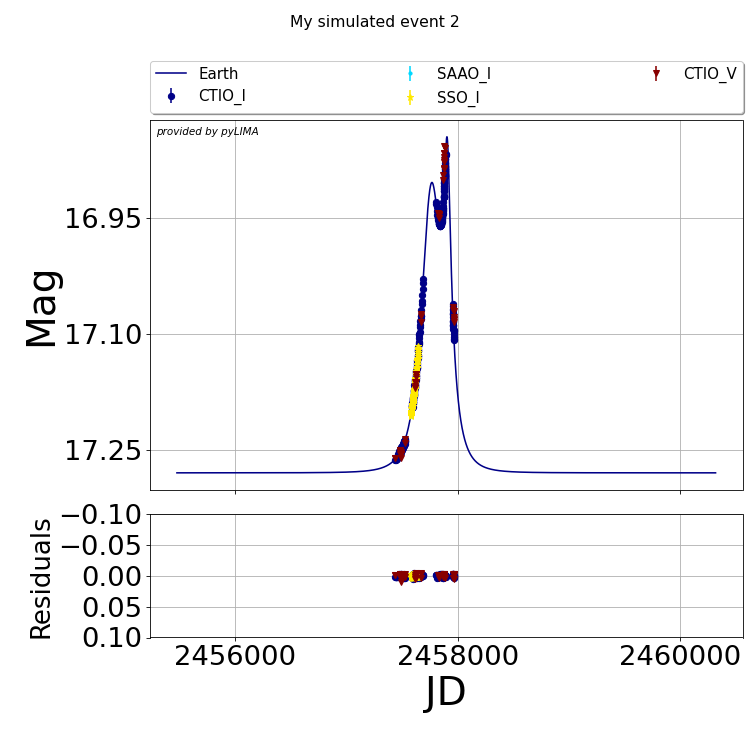

In [34]:
from pyLIMA.outputs import pyLIMA_plots
pyLIMA_plots.plot_lightcurves(dspl, dspl_parameters)
plt.show()

A short commentary to explain the DSPL parameters in this example:

In [35]:
print (dspl_parameters)
parameter_commentary = ['Time of minimum impact parameter for source 1',
                        'minimum impact parameter for source 1',
                        'difference of time of minimum impact parameter between the two sources',
                        'difference of minimum impact parameters between the two sources',
                        'angular Einstein radius crossing time',
                        'flux ratio in I between source 1 and source 2',
                        'flux ratio in V between source 1 and source 2',
                        'source flux of source 1 for telescope CTIO_I (survey telescope)',
                        'blending ratio of source 1 for telescope CTIO_I (survey telescope)',
                        'source flux of source 1 for telescope SAAO_I',
                        'blending ratio of source 1 for telescope SAAO_I',
                        'source flux of source 1 for telescope SSO_I',
                        'blending ratio of source 1 for telescope SSO_I',
                        'source flux of source 1 for telescope CTIO_V',
                        'blending ratio of source 1 for telescope CTIO_V',
                        ]

for key in dspl.model_dictionnary.keys():
    indice = dspl.model_dictionnary[key]
    print (key, ' = ', dspl_parameters[indice], ' : ', parameter_commentary[indice] )


[2457760.216627234, 0.8605811108889658, 143.4484970433387, -0.6046788112617074, 116.43231096591524, 0.15157064165919296, 0.18958495421162946, 10764.652136298328, 401.7908108489392, 10764.652136298328, 401.7908108489392, 10764.652136298328, 401.7908108489392, 1940.8858775927754, 296.4831389524342]
t0  =  2457760.216627234  :  Time of minimum impact parameter for source 1
u0  =  0.8605811108889658  :  minimum impact parameter for source 1
delta_t0  =  143.4484970433387  :  difference of time of minimum impact parameter between the two sources
delta_u0  =  -0.6046788112617074  :  difference of minimum impact parameters between the two sources
tE  =  116.43231096591524  :  angular Einstein radius crossing time
q_flux_I  =  0.15157064165919296  :  flux ratio in I between source 1 and source 2
q_flux_V  =  0.18958495421162946  :  flux ratio in V between source 1 and source 2
fsource_CTIO_I  =  10764.652136298328  :  source flux of source 1 for telescope CTIO_I (survey telescope)
fblend_CTIO_

Let's try to fit this now! (This can take a while!) 

You can check the first tutorial again for a detailed explanation if needed.

In [36]:
from pyLIMA.fits import DE_fit

my_fit = DE_fit.DEfit(dspl)
my_fit.fit()
my_fit.fit_results['best_model']

differential_evolution step 1: f(x)= 63180.4
differential_evolution step 2: f(x)= 63180.4
differential_evolution step 3: f(x)= 57526.5
differential_evolution step 4: f(x)= 57526.5
differential_evolution step 5: f(x)= 57526.5
differential_evolution step 6: f(x)= 57526.5
differential_evolution step 7: f(x)= 57526.5
differential_evolution step 8: f(x)= 52278
differential_evolution step 9: f(x)= 47506.5
differential_evolution step 10: f(x)= 47506.5
differential_evolution step 11: f(x)= 47506.5
differential_evolution step 12: f(x)= 47506.5
differential_evolution step 13: f(x)= 47506.5
differential_evolution step 14: f(x)= 47506.5
differential_evolution step 15: f(x)= 47506.5
differential_evolution step 16: f(x)= 43776.8
differential_evolution step 17: f(x)= 43776.8
differential_evolution step 18: f(x)= 43776.8
differential_evolution step 19: f(x)= 43776.8
differential_evolution step 20: f(x)= 43776.8
differential_evolution step 21: f(x)= 43776.8
differential_evolution step 22: f(x)= 43776.8

array([ 2.45775963e+06,  7.36762055e-01,  1.43646567e+02, -9.67545392e-01,
        1.28002280e+02,  1.76998098e-01,  2.19744545e-01])

Compare your DSPL fit parameters with what you defined in the DSPL simulation above:

In [37]:
print(my_fit.fit_results['best_model'] - dspl_parameters[0:7])

[-0.58650949 -0.12381906  0.19806971 -0.36286658 11.5699692   0.02542746
  0.03015959]


Plot and constrast the optimized fit results and the simulated light curve:

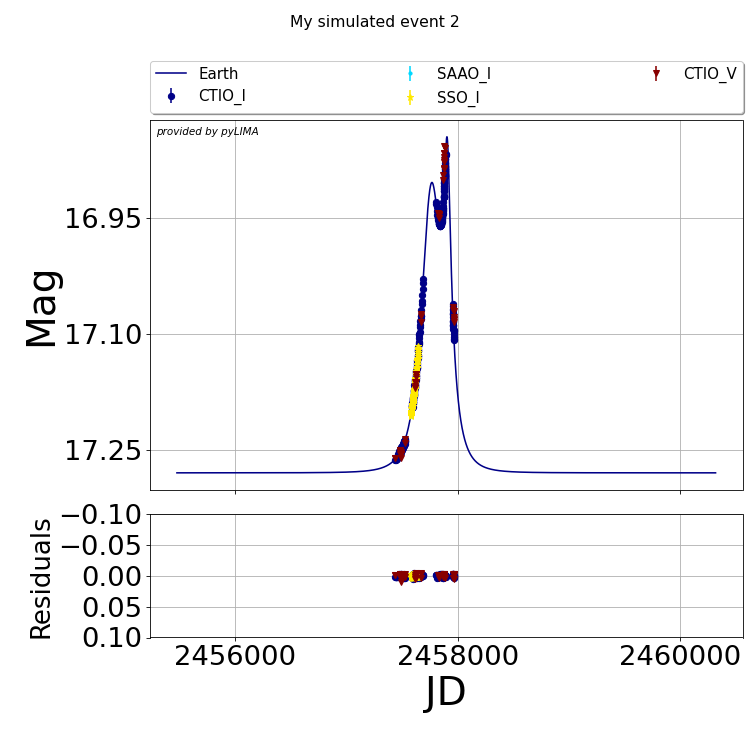

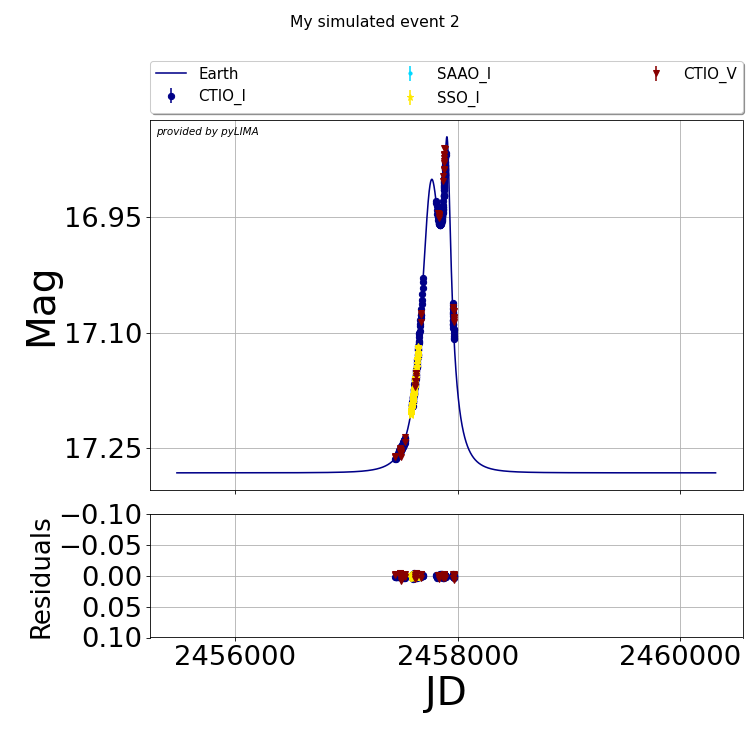

In [38]:
pyLIMA_plots.plot_lightcurves(dspl, my_fit.fit_results['best_model'])
pyLIMA_plots.plot_lightcurves(dspl, dspl_parameters)
plt.show()

This concludes tutorial 3.